# Stage 1.1

---

### _Content_:

1. Data Generation
2. Preprocessing the dataset
3. Pre-Training Setup
4. Training
5. Evaluation & Visualization
 
### _Requirements_:

1. numpy
2. matplotlib
3. scikit-learn

---

In [30]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Generation

In [31]:
# Set a global seed for reproducibility (To get the same random initializations)
# np.random.seed(36)

In [32]:
# Assign the constants
N_SAMPLES = 500
N_INPUT_FEATURES = 1
N_OUTPUT_FEATURES = 1

In [33]:
NetworkAchitecture = {
    "layer_1": {"w": np.array([[1.0], [1.0]]), "b": np.array([1.0, 1.0])},
    "layer_2": {"w": np.array([[1.0, 1.0]]), "b": np.array([1.0])},
}
NetworkAchitecture = {
    "layer_1": {
        "w": np.random.uniform(low=-1, high=1, size=(2, 1)),
        "b": np.array([1.0, 0.3]),
    },
    "layer_2": {
        "w": np.random.uniform(low=-1, high=1, size=(1, 2)),
        "b": np.array([1.0]),
    },
}

In [34]:
layer1_w = NetworkAchitecture["layer_1"]['w']
layer1_b = NetworkAchitecture["layer_1"]['b']
layer2_w = NetworkAchitecture["layer_2"]['w']
layer2_b = NetworkAchitecture["layer_2"]['b']

# Check the shapes of the weights and biases
print(f"Layer 1 Weights shape: {layer1_w.shape}")
print(f"Layer 1 Biases shape: {layer1_b.shape}")
print(f"Layer 2 Weights shape: {layer2_w.shape}")
print(f"Layer 2 Biases shape: {layer2_b.shape}")


Layer 1 Weights shape: (2, 1)
Layer 1 Biases shape: (2,)
Layer 2 Weights shape: (1, 2)
Layer 2 Biases shape: (1,)


In [35]:
def interesting_function(x):
    x = np.asarray(x)
    y = np.where(x > 5, 2 * x - 10, 0)
    return y


X = np.random.uniform(low=-10.0, high=10.0, size=(N_SAMPLES,1))
y = interesting_function(X)

In [36]:
# Check the shapes of X and y
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (500, 1), y shape: (500, 1)


In [37]:
X[:3]

array([[-5.07972656],
       [ 5.1726242 ],
       [ 2.0244187 ]])

In [38]:
y[:3]

array([[0.       ],
       [0.3452484],
       [0.       ]])

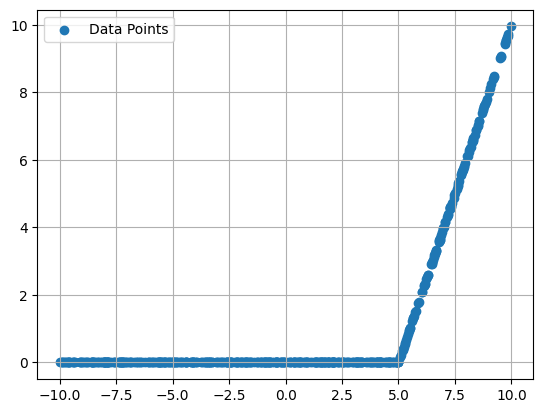

In [39]:
plt.scatter(X, y, label="Data Points")
plt.grid(True)
plt.legend()
plt.show()

## 2. Preprocessing the dataset

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

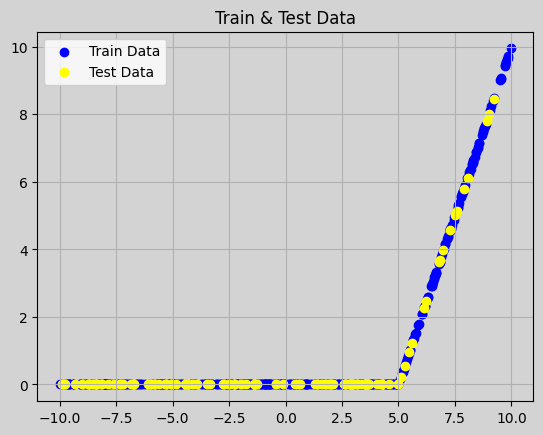

In [42]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('lightgray')
ax.set_facecolor('lightgray')

ax.scatter(X_train, y_train, color='blue', label='Train Data')
ax.scatter(X_test, y_test, color='yellow', label='Test Data')
ax.legend()
ax.grid(True)
ax.set_title("Train & Test Data")

plt.show()

## 3. Pre-Training Setup

Using MSE (Mean Squared Error as a loss function)

In [43]:
def compute_loss(y_pred, y_real):
    if y_pred.shape != y_real.shape:
        raise ValueError(f"Shapes must be equal, got {y_pred.shape} and {y_real.shape}")
    errors = y_pred - y_real
    return np.mean(errors**2)

In [44]:
def relu(X):
    return np.maximum(0, X)


def relu_derivative(X):
    X = np.asarray(X)
    return (X > 0).astype(np.float32)

In [45]:
history = {"epoch": [], "loss": []}

## 4. Training

In [46]:
MAX_EPOCHS: int = 500
MIN_LOSS: float = 0.01
LEARNING_RATE: float = 0.01

In [47]:
class Adam:
    def __init__(self, w, b, learning_rate=0.0001, beta_m=0.9, beta_v=0.95):

        self.w = np.asarray(w)
        self.b = np.asarray(b)
        self.lr = learning_rate

        self.beta_m = beta_m
        self.beta_v = beta_v

        self.weight_m = 0
        self.bias_m = 0
        self.weight_prev_m = 0
        self.bias_prev_m = 0

        self.weight_v = 0
        self.bias_v = 0
        self.weight_prev_v = 0
        self.bias_prev_v = 0
        
    def step(self, epoch, w_gradient, b_gradient):
        self.weight_prev_m = self.weight_m
        self.bias_prev_m = self.bias_m
        self.weight_prev_v = self.weight_v
        self.bias_prev_v = self.bias_v
        
        self.weight_m = self.beta_m * self.weight_prev_m + (1 - self.beta_m) * w_gradient
        self.bias_m = self.beta_m * self.bias_prev_m + (1 - self.beta_m) * b_gradient
        
        self.weight_v = self.beta_v * self.weight_prev_v + (1 - self.beta_v) * (w_gradient ** 2)
        self.bias_v = self.beta_v * self.bias_prev_v + (1 - self.beta_v) * (b_gradient ** 2)
        
        # Bias correction
        weight_m_hat = self.weight_m / (1 - self.beta_m ** (epoch + 1))
        bias_m_hat = self.bias_m / (1 - self.beta_m ** (epoch + 1))
        weight_v_hat = self.weight_v / (1 - self.beta_v ** (epoch + 1))
        bias_v_hat = self.bias_v / (1 - self.beta_v ** (epoch + 1))
        
        # Update weights and biases
        self.w -= self.lr * weight_m_hat / (np.sqrt(weight_v_hat) + 1e-8)
        self.b -= self.lr * bias_m_hat / (np.sqrt(bias_v_hat) + 1e-8)
        return self.w, self.b
    
    def get_params(self):
        return {"w": self.w, "b": self.b}


In [48]:
class Optimizer:
    """
    An Adam Optimizer
    """

    def __init__(self, w, b, learning_rate=0.0001, beta_1=0.9):
        self.w = np.asarray(w)
        self.b = np.asarray(b)
        self.lr = learning_rate

        self.beta_1 = beta_1
        
        self.w_momentum = 0
        self.b_momentum = 0
        self.previous_w_momentum = 0
        self.previous_b_momentum = 0

        
        self.w_second = 0
        self.b_second


    def step(self, epoch, w_gradient, b_gradient):
        self.previous_w_momentum = self.w_momentum
        self.previous_b_momentum = self.b_momentum
        
        self.w_momentum = (self.beta_1 * self.previous_w_momentum) + (w_gradient * self.lr)
        self.b_momentum = (self.beta_1 * self.previous_b_momentum) + (b_gradient * self.lr)
        
        self.w -= self.w_momentum
        self.b -= self.b_momentum

    def get_params(self):
        return {"w": self.w, "b": self.b}

In [49]:
optimizer_1 = Adam(w=layer1_w, b=layer1_b, learning_rate=LEARNING_RATE)
optimizer_2 = Adam(w=layer2_w, b=layer2_b, learning_rate=LEARNING_RATE)


In [50]:
epoch: int = 0

while True:

    # Forward Pass
    params_1 = optimizer_1.get_params()
    layer1_w = params_1["w"]
    layer1_b = params_1["b"]
    
    params_2 = optimizer_2.get_params()
    layer2_w = params_2["w"]
    layer2_b = params_2["b"]


    z_1 = X_train @ layer1_w.T + layer1_b
    # print("z_1 shape:", z_1.shape)
    A_1 = relu(z_1)
    # print("A_1 shape:", A_1.shape)

    z_2 = A_1 @ layer2_w.T + layer2_b
    # print("z_2 shape:", z_2.shape)
    A_2 = relu(z_2)
    # print("A_2 shape:", A_2.shape)

    y_pred = A_2
    loss = compute_loss(y_pred=y_pred, y_real=y_train)

    if loss <= MIN_LOSS or epoch >= MAX_EPOCHS:
        print("Early stopping condition met.")
        break

    # Backward pass

    errors = y_pred - y_train
    loss_gradient = 2 / len(X_train) * errors
    upstream_gradient_2 = loss_gradient * relu_derivative(z_2)
    layer2_w_gradient = upstream_gradient_2.T @ A_1
    layer2_b_gradient = sum(upstream_gradient_2)
    # print(layer2_w_gradient.shape, layer2_w.shape)

    upstream_gradient_1 = upstream_gradient_2 @ layer2_w * relu_derivative(z_1)
    layer1_w_gradient = upstream_gradient_1.T @ X_train
    layer1_b_gradient = sum(upstream_gradient_1)
    # print(layer1_w_gradient.shape, layer1_w.shape)

    # Optimization
    optimizer_1.step(epoch=epoch, w_gradient=layer1_w_gradient, b_gradient=layer1_b_gradient)
    optimizer_2.step(epoch=epoch, w_gradient=layer2_w_gradient, b_gradient=layer2_b_gradient)

    history["epoch"].append(epoch)
    history["loss"].append(loss)

    epoch += 1
print(f"Training Finished:\t Epoch: {epoch} | Loss: {loss}")

Early stopping condition met.
Training Finished:	 Epoch: 299 | Loss: 0.009513778002092197


## 5. Evaluation & Visualization

### Training

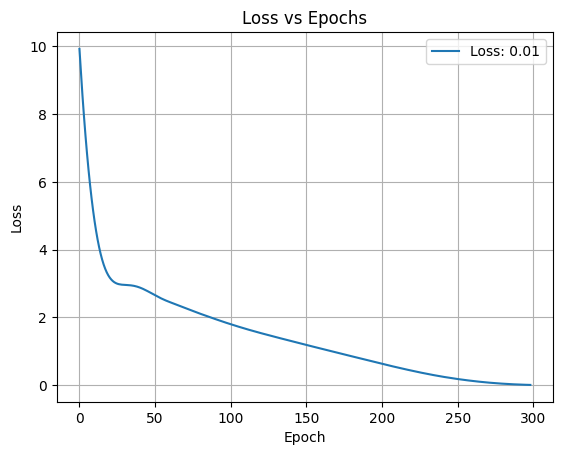

In [51]:
plt.plot(history['epoch'], history['loss'], label=f'Loss: {loss:.2f}')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

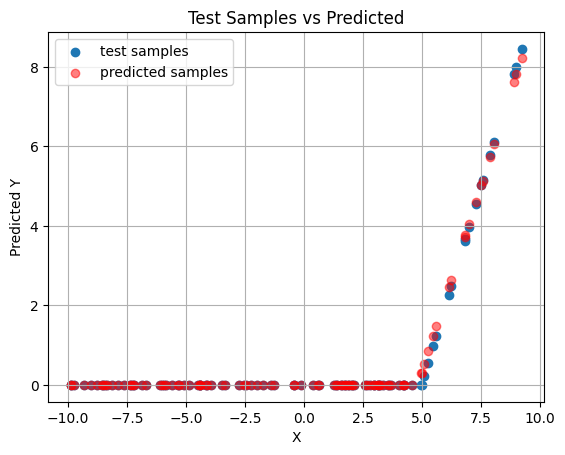

In [52]:
plt.scatter(X_test, y_test, label='test samples')

y_pred_test = relu(X_test @ layer1_w.T + layer1_b) @ layer2_w.T + layer2_b
plt.scatter(X_test, relu(y_pred_test), label='predicted samples', color='red', alpha=0.5)

plt.title("Test Samples vs Predicted")
plt.xlabel("X")
plt.ylabel("Predicted Y")
plt.grid()
plt.legend()
plt.show()